# Laboratorio 2: CompuAlpes

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con **determinar el precio adecuado para un portatil** ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.

Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea **construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación**. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

### Carga de los datos

In [3]:
df = pd.read_csv('./data/202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv')

## 1. Entendimiento de los datos

In [4]:
df.shape

(1216, 14)

In [5]:
df.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [8]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
274,917,MSI,Gaming,16,2.70,11.352695,0,0,127.335675,Intel Core i7,1000.0,256,Nvidia,Windows
1063,659,Dell,Gaming,32,4.42,12.029883,0,1,254.671349,Intel Core i7,1000.0,512,Nvidia,Windows
974,26,Apple,Ultrabook,8,1.35,10.977717,0,0,127.677940,Intel Core i5,0.0,0,Intel,Mac
462,201,Lenovo,Notebook,4,2.10,10.176070,0,0,100.454670,Intel Core i5,0.0,128,Intel,Windows
321,306,HP,2 in 1 Convertible,16,1.28,11.563885,1,0,165.632118,Intel Core i7,0.0,256,Intel,Windows


Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Con ayuda de los expertos, se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) `Price`.

Hay variables booleanas que deberían influir en el precio de una laptop como Ips pero para este modelo no parece aplicar.
[Aquí se habla de eso](https://towardsdatascience.com/machine-learning-102-logistic-regression-9e6dc2807772)

In [7]:
features = ['Ram', 'Weight', 'Ppi', 'HDD', 'SSD']

In [9]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price     0.012336
Ram       0.000000
Weight    0.018914
Ppi       0.009868
HDD       0.013158
SSD       0.000000
dtype: float64

In [10]:
duplicated_rows = df.loc[df.duplicated(subset = features, keep = False)].shape[0]
duplicated_rows

631

In [11]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.5189144736842105


In [12]:
duplicated_rows = df.loc[df.duplicated(subset = features + ['Price'], keep = False)].shape[0]
duplicated_rows

22

In [46]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.018092105263157895


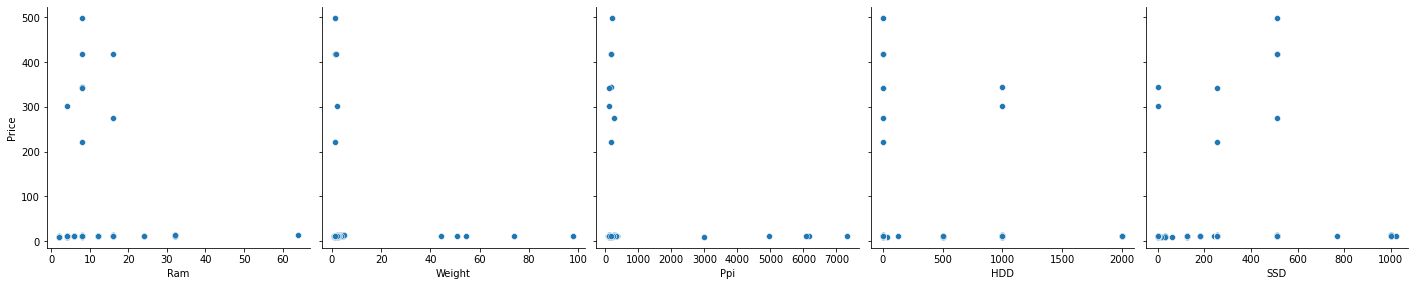

In [13]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')

<Axes: >

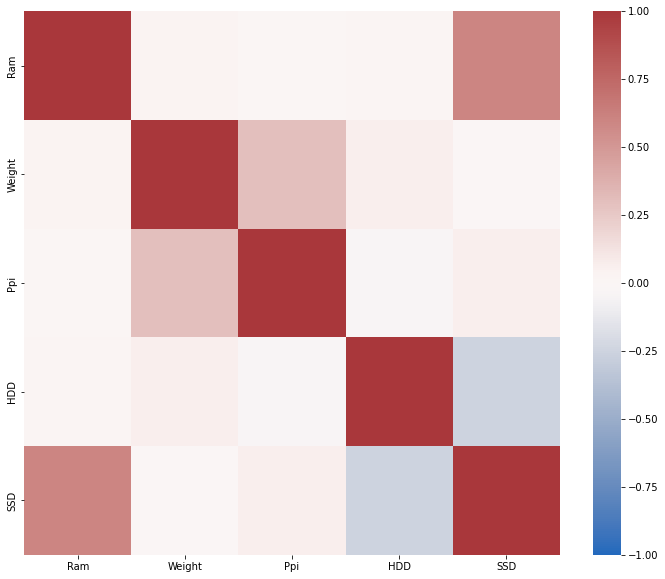

In [14]:
plt.figure(figsize = (12, 10))
sns.heatmap(df[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

## 2. Preparación de datos

In [15]:
df = df.dropna(subset = ['Price'] + features)

In [16]:
df.shape

(1170, 14)

In [17]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price     0.0
Ram       0.0
Weight    0.0
Ppi       0.0
HDD       0.0
SSD       0.0
dtype: float64

## 3. Particionamiento del conjunto de datos en entrenamiento y prueba

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["Price"], test_size=0.3, random_state=1)

In [20]:
X_train.shape, y_train.shape

((819, 5), (819,))

In [23]:
X_test.shape, y_test.shape  

((351, 5), (351,))

## 4. Entrenamiento de un primer modelo de regresión lineal


In [24]:
regression= LinearRegression()  

In [25]:
regression.fit(X_train, y_train)

LinearRegression()

## 5. Interpretación de los coeficientes y del intercepto

In [26]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,-0.245459
1,Weight,-0.028726
2,Ppi,-0.000291
3,HDD,0.001466
4,SSD,0.011044


In [27]:
regression.intercept_

11.496786319208113

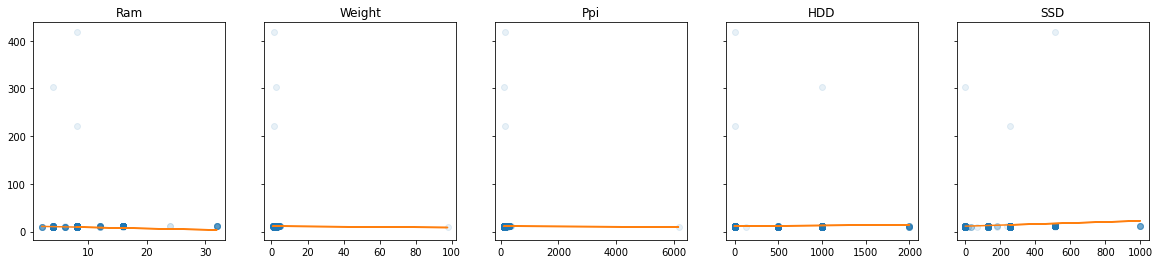

In [28]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 4.2. Validación (evaluación) del modelo

**Mean Absolute Error (MAE)**

In [29]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 2.492482149619419
Test: 3.9967052941449563


**Root Mean Squeared Error (RMSE)**

In [30]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 18.913586064623903
Test: 33.768426138132504


**Análisis del error**

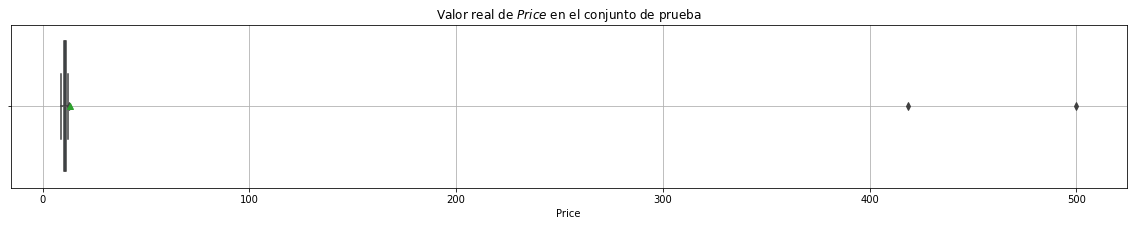

In [32]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Price}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [33]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    351.000000
mean      13.341128
std       33.934355
min        9.134616
25%       10.328152
50%       10.841452
75%       11.234697
99%       12.312879
max      499.766079
Name: Price, dtype: float64